#### Import and load

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from matplotlib import rcParams
import h5py
import hashlib
import time
from typing import List
import sys
if os.path.abspath("../") not in sys.path:
    sys.path.append(os.path.abspath("../"))
import aux_analysis as aux
import spikeye.visualize as v
from sklearn import manifold
from sklearn import decomposition
from synapsbi.utils import apply_n_conditions, load_and_merge
from matplotlib.colors import LinearSegmentedColormap
import torch
from aux_analysis import MLP
from synapsbi.analyse import default_x
from sbi.analysis import pairplot, conditional_pairplot, conditional_corrcoeff
import pickle

color_input="#36454F"
color_ee = "#A52A2A"
color_ei = (242/256, 140/256, 40/256)
color_ie = (8/256, 143/256, 143/256)
color_ii = (47/256, 85/256, 151/256)

color_pi0 = (127/255, 127/255, 127/255)
color_pi1 = (27/255, 158/256, 119/255)
color_pi2 = (217/255, 95/256, 2/255)
color_pi3 = (117/256, 112/256, 179/256)

In [4]:
save_dir = "../data_synapsesbi/bg_CVAIF_EEIE_T4wvceciMLP/"
dataset = load_and_merge(save_dir,
                         ("bg_CVAIF_EEIE_T4wvceciMLP_all.npy",))

retrieved 328990/328990 simulations


#### Accumulation plot

In [5]:
dataset_list = []
dataset_list.append(load_and_merge(save_dir, ("0rate_filter0_metrics.npy",)))
dataset_list.append(load_and_merge(save_dir, ("0rate_filter1_metrics.npy",)))
dataset_list.append(load_and_merge(save_dir, ("0r_f2_1wb_f2_2wbcv_f0_metrics.npy",)))
dataset_list.append(load_and_merge(save_dir, ("0r_f2_1wb_f2_2wbcv_f3_2wbwcac_f0_metrics.npy",)))

n_datasets = len(dataset_list)
n_thetas = len(dataset_list[0]['theta'][0]) - 1

cond_no_nan = ("rate", 0, 1000)
cond_r = ("rate", 1, 50)
cond_cv = ("cv_isi", 0.7, 1000)
cond_sf = ("spatial_Fano", 0.5, 2.5)
cond_tf = ("temporal_Fano", 0.5, 2.5)
cond_ac = ("auto_cov", 0, 0.1)
cond_fft = ("fft", 0, 1)
cond_wb = ("w_blow", 0, 0.1)
cond_srt = ("std_rate_temporal", 0, 0.5)
cond_srs = ("std_rate_spatial", 0, 5)
cond_wc = ("w_creep", 0, 0.05)
cond_ri = ("rate_i", 1, 50)
cond_weef =("weef", 0 , 0.5)
cond_wief =("wief", 0 , 5)


cond_chosen_list = [(cond_r,cond_ri),
                    (cond_wb,cond_wc,cond_weef,cond_wief),
                    (cond_cv,cond_sf,cond_tf,cond_ac,cond_fft,cond_srt,cond_srs),
                    (cond_r,cond_ri,
                     cond_wb,cond_wc,cond_weef,cond_wief,
                     cond_cv,cond_sf,cond_tf,cond_ac,cond_fft,cond_srt,cond_srs)]
n_conditions_chosen = len(cond_chosen_list)

fracs_list = np.zeros((n_conditions_chosen, n_datasets))
for i, cond in enumerate(cond_chosen_list):
    for d in range(n_datasets):
        fracs_list[i,d] = np.sum(apply_n_conditions(dataset_list[d], cond))/len(dataset_list[d])

retrieved 11000/11000 simulations
retrieved 11000/11000 simulations
retrieved 18000/18000 simulations
retrieved 15500/15500 simulations


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


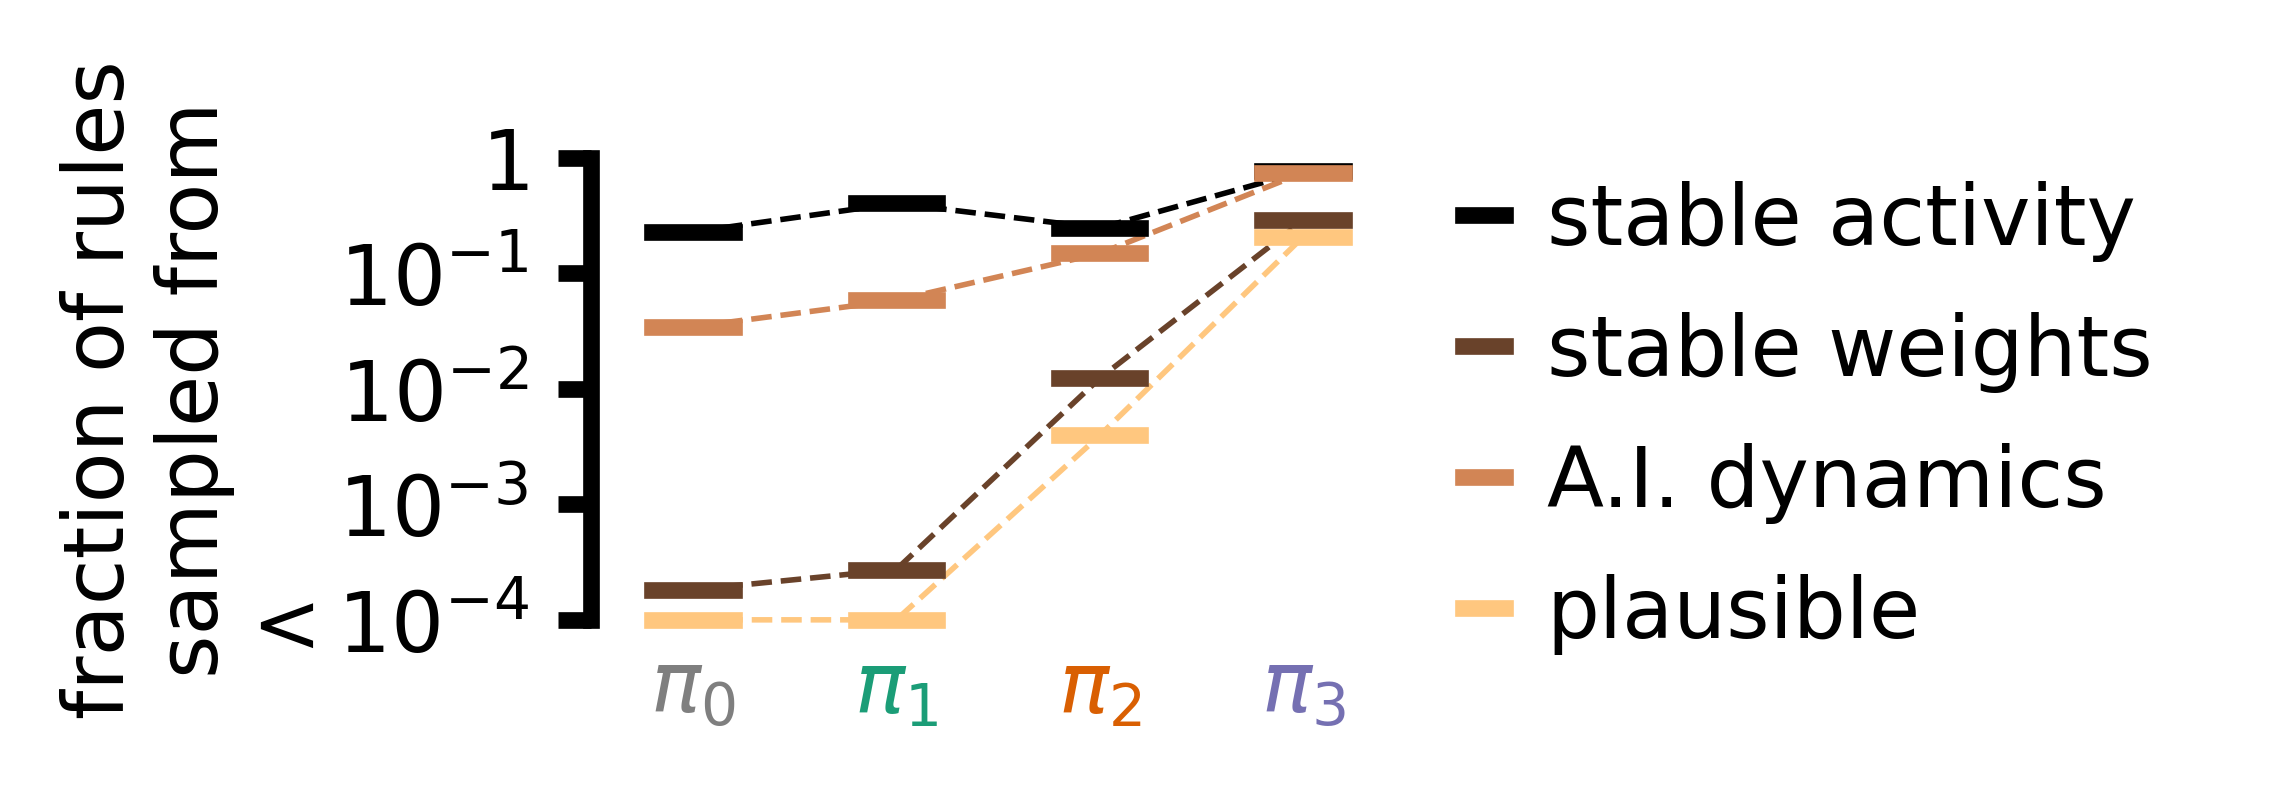

In [6]:
aux.accumulation_plot(fracs_list=fracs_list,
                      colormap=plt.cm.copper,
                      figsize=(1.75, 1),
                      clip_frac_low=1e-4,
                      condition_labels=["stable activity", "stable weights", "A.I. dynamics", "plausible"],
                      ylim=[1e-4,1],
                      yticks=[1e-4,1e-3,1e-2,0.1,1],
                      yticklabels=[r'$<10^{-4}$',r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$1$'],
                      xlabel=None,
                      xticklabels=[r'$\pi_0$', r'$\pi_1$', r'$\pi_2$', r'$\pi_3$'],
                      ylabel="fraction of rules\nsampled from",
                      y_loc_leg=-0.2,
                      linewidth=2,
                      axwidth=2,
                      font="Arial",
                      fontsize=10,
                      xlim=[-0.5,3.5],
                      ms=0,
                      marker="o",
                      labelspacing=0.6,
                      xlabel_colors = [color_pi0, color_pi1, color_pi2, color_pi3],
                      l=0.2)

#### PCA evolution of dimensionality of posteriors

In [7]:
#we need to rescale the thetas so that for prior they all have mean 0 and variance 1:
dataset_list_whitened = []
for d in range(n_datasets):
    dataset_list_whitened.append(np.copy(dataset_list[d]))
    for theta_num in range(n_thetas):
        if theta_num in [0,1]:
            dataset_list_whitened[d]['theta'][:,theta_num] = (dataset_list_whitened[d]['theta'][:,theta_num] - 0.5)/np.sqrt((1**2)/12)
        else:
            dataset_list_whitened[d]['theta'][:,theta_num] = (dataset_list_whitened[d]['theta'][:,theta_num])/np.sqrt((2**2)/12)


pca_list = [decomposition.PCA(whiten=True) for i in range(n_datasets)]
explained_variance_ratios = []
for d in range(n_datasets):
    pca_list[d].fit(dataset_list_whitened[d]['theta'][:,:-1])
    explained_variance_ratios.append(pca_list[d].explained_variance_ratio_)
    
explained_variance_ratios = np.array(explained_variance_ratios)
print(explained_variance_ratios.shape)

(4, 22)


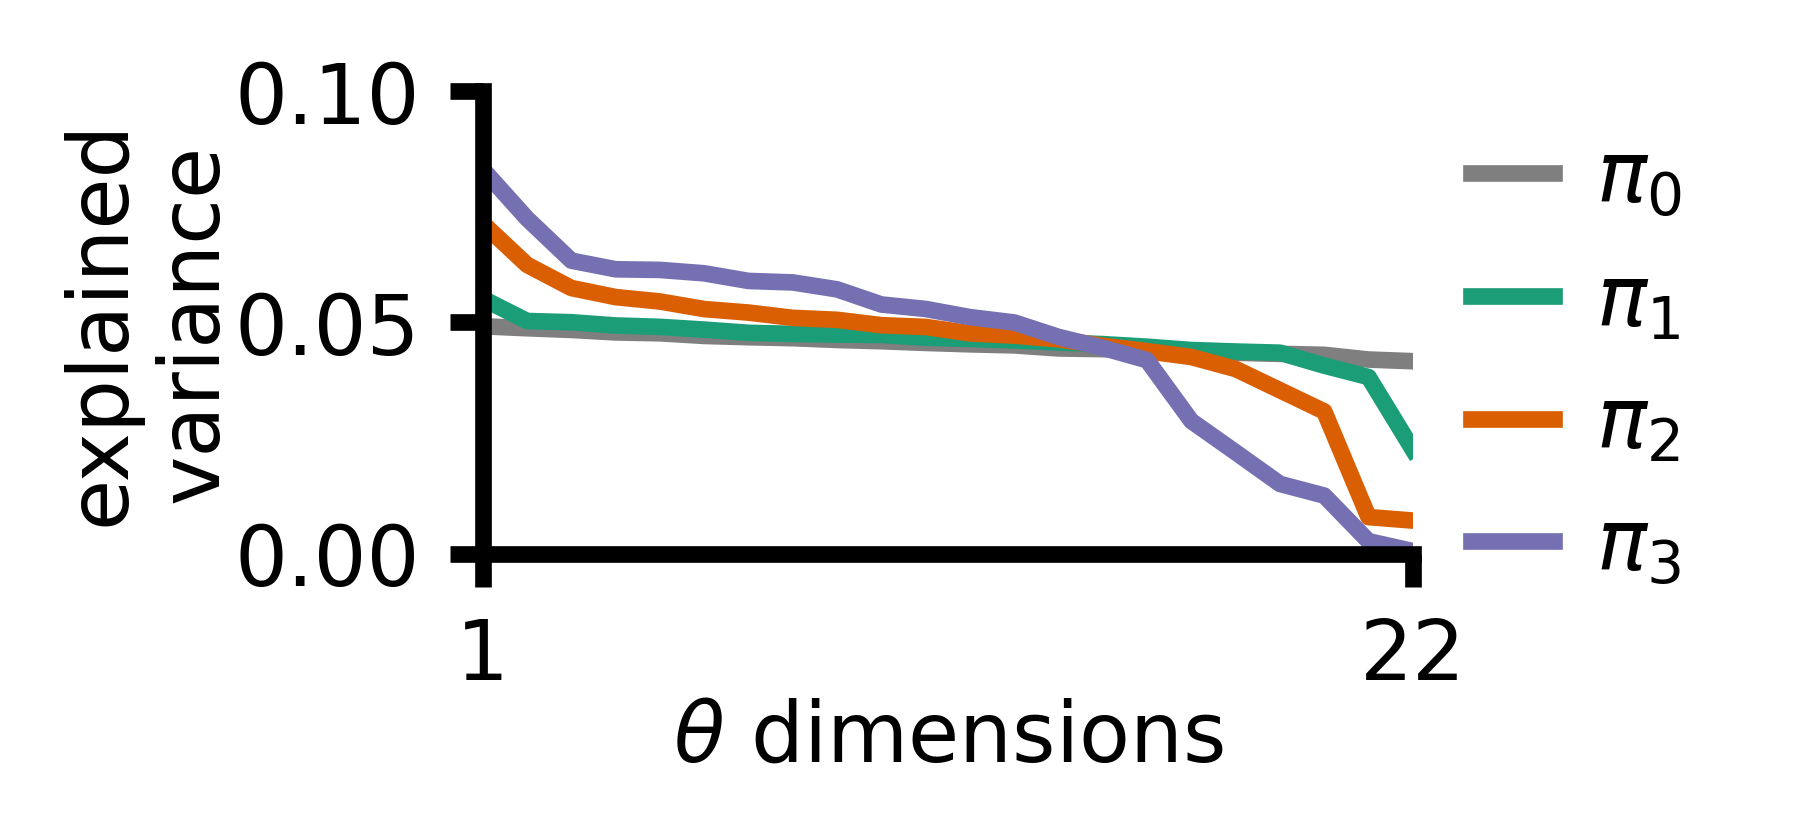

In [9]:
label_plots = ["prior"]
for i in range(n_datasets-1):
    label_plots.append("round " + str(i+1))

aux.plot_evol_dim_post(exp_var_ratios=explained_variance_ratios,
                   font = "Arial",
                   fontsize=10,
                   linewidth=2,
                   axwidth=2,
                   dpi=600,
                   labels=[r'$\pi_0$', r'$\pi_1$', r'$\pi_2$', r'$\pi_3$'],
                   figsize=(2, 1),
                   xticks=[1,22],
                   xlim=[1,22],
                   xlabel=r'$\theta$' + " dimensions",
                   ylim=[0,0.1],
                   ylabel="explained\nvariance",
                   y_loc_leg=-0.2,
                   labelspacing=0.5,
                   colors = [color_pi0, color_pi1, color_pi2, color_pi3])

#### Plot pre-post protocol for MLP

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


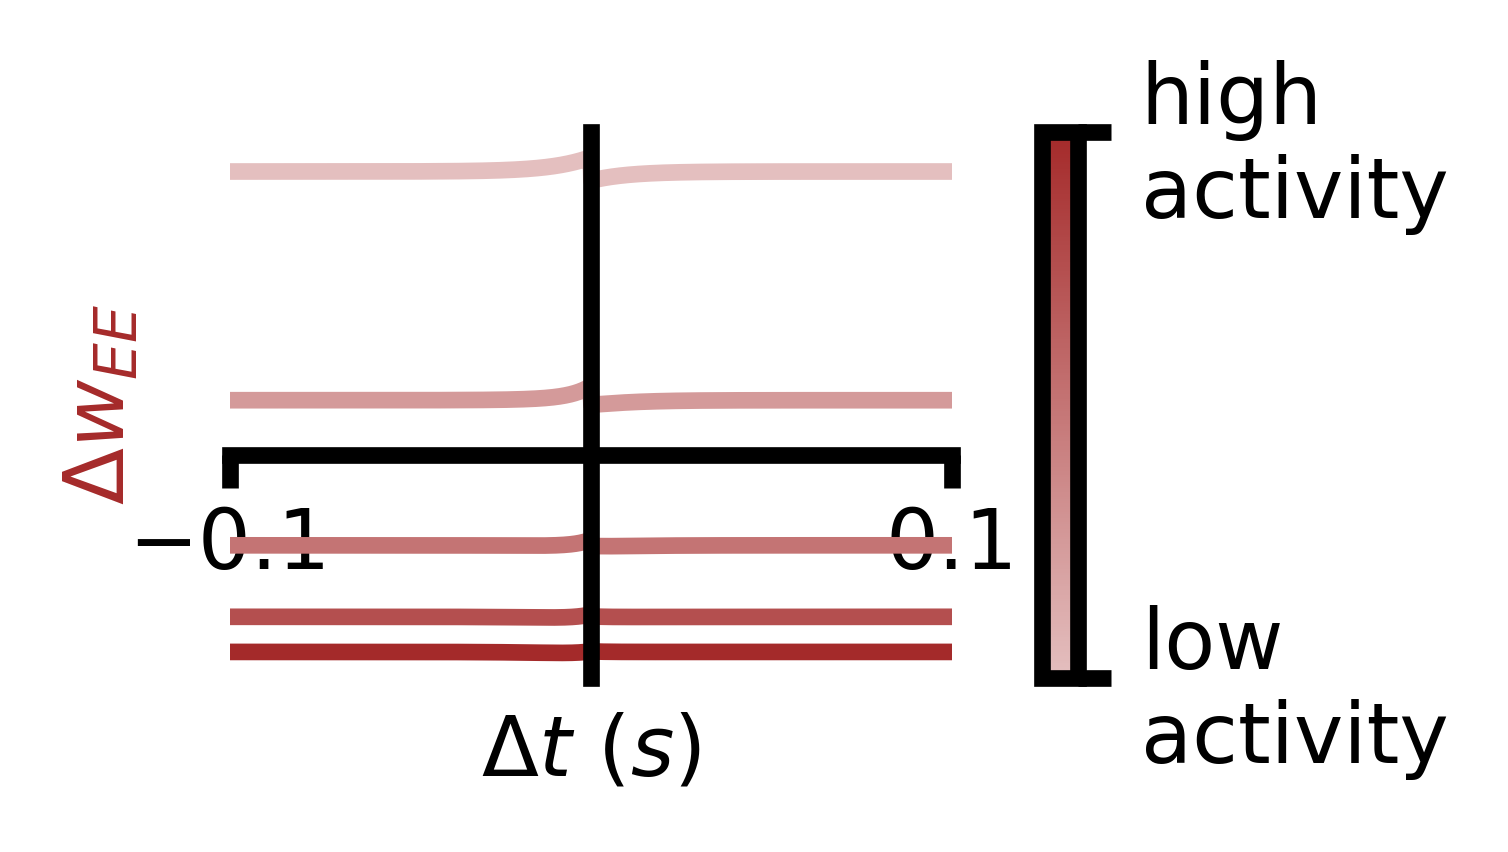

In [10]:
net_EE_pre = torch.load("/home/bconfavr/Documents/synapsesbi/notebooks/Task_design/test_model")
net_EE_post = torch.load("/home/bconfavr/Documents/synapsesbi/notebooks/Task_design/test_model")
dtype = torch.float

rule = [1.29939720e-01, 4.79347276e-04, 2.96384186e-01, -4.67114270e-01, 4.24380839e-01, 6.47823513e-01, 3.48782279e-02, 3.41926664e-01, 3.47279757e-01, 3.47070426e-01, -3.15040410e-01, -6.94070637e-01, 1.87801853e-01, -2.09873557e-01, -3.75144660e-01, 8.85631084e-01, 1.43499836e-01, 6.42546713e-01, -2.99585074e-01, 5.86552262e-01, -9.38091934e-01, -3.76303978e-02, 8.75709915e+00]

# other example in supp
# rule = [ 0.02669999,  0.14428829,  0.76947457, -0.06014529, -0.22276115,  0.56693155, -0.15901111,  0.84426659,  0.44993687, -0.78366649,  0.69989562, -0.76975691, -0.49002439,  0.15140794, -0.11839931, -0.76659781,  0.53133011,  0.90907252, -0.80171049,  0.55569726, -0.8491962 ,  0.37236875,  8.93461609]

P = 0.3
colors = [((255-P*(255-165))/255, (255-P*(255-42))/255, (255-P*(255-42))/255), (165/256, 42/256, 42/256)]
cmap_ee = LinearSegmentedColormap.from_list("mycmap", colors)

with torch.no_grad():
    net_EE_pre.eta = rule[0]
    net_EE_pre.l3.weight.copy_(torch.tensor(rule[2:6], dtype=dtype))
    net_EE_pre.l3.bias.copy_(torch.tensor([rule[6]], dtype=dtype))
    
with torch.no_grad():
    net_EE_post.eta = rule[0]
    net_EE_post.l3.weight.copy_(torch.tensor(rule[7:11], dtype=dtype))
    net_EE_post.l3.bias.copy_(torch.tensor([rule[11]], dtype=dtype))
    
rescale_trace=2.; 
rescale_v=15.;
rescale_w=1.;
rescale_cexc=15.;
rescale_cinh=15.;

n_cond = 5
var_dict = {"w": np.linspace(0.01,0.1, num=n_cond),
            "v": np.linspace(-0.07,-0.05, num=n_cond),
            "cexc": np.linspace(0,0.3, num=n_cond),
            "cinh": np.linspace(0,0.3, num=n_cond),
            "xpre": np.linspace(0,5, num=n_cond),
            "xpost": np.linspace(0,5, num=n_cond)}

aux.plot_rule_MLP(net_pre=net_EE_pre,
          net_post=net_EE_post,
          var_dict=var_dict,
          tau_pre1=0.01,
          tau_pre2=0.1,
          tau_post1=0.01,
          tau_post2=0.1,
          n_bins=1000,
          x_lim=[-0.1,0.1],
          dtype=dtype,
          xticks_pad=2,
          yticks_pad=0,
          color=color_ee,
          linewidth=2,
          axwidth=2,
          y_lim=None,
          figsize=(2.5,1.5),
          rescale_trace=2,
          dpi=600,
          fontsize=10,
          x_ticks=[-0.1, 0.1],
          y_ticks= [],
          x_label=r'$\Delta t \ (s)$',
          labelpad_xlabel=15,
          y_label=r'$\Delta w_{EE}$',
          labelpad_ylabel=50,
          color_ylabel=color_ee,
          cmap=cmap_ee,
          cbarticks=[0,1],
          cbarticklabels=["low\nactivity", "high\nactivity"])

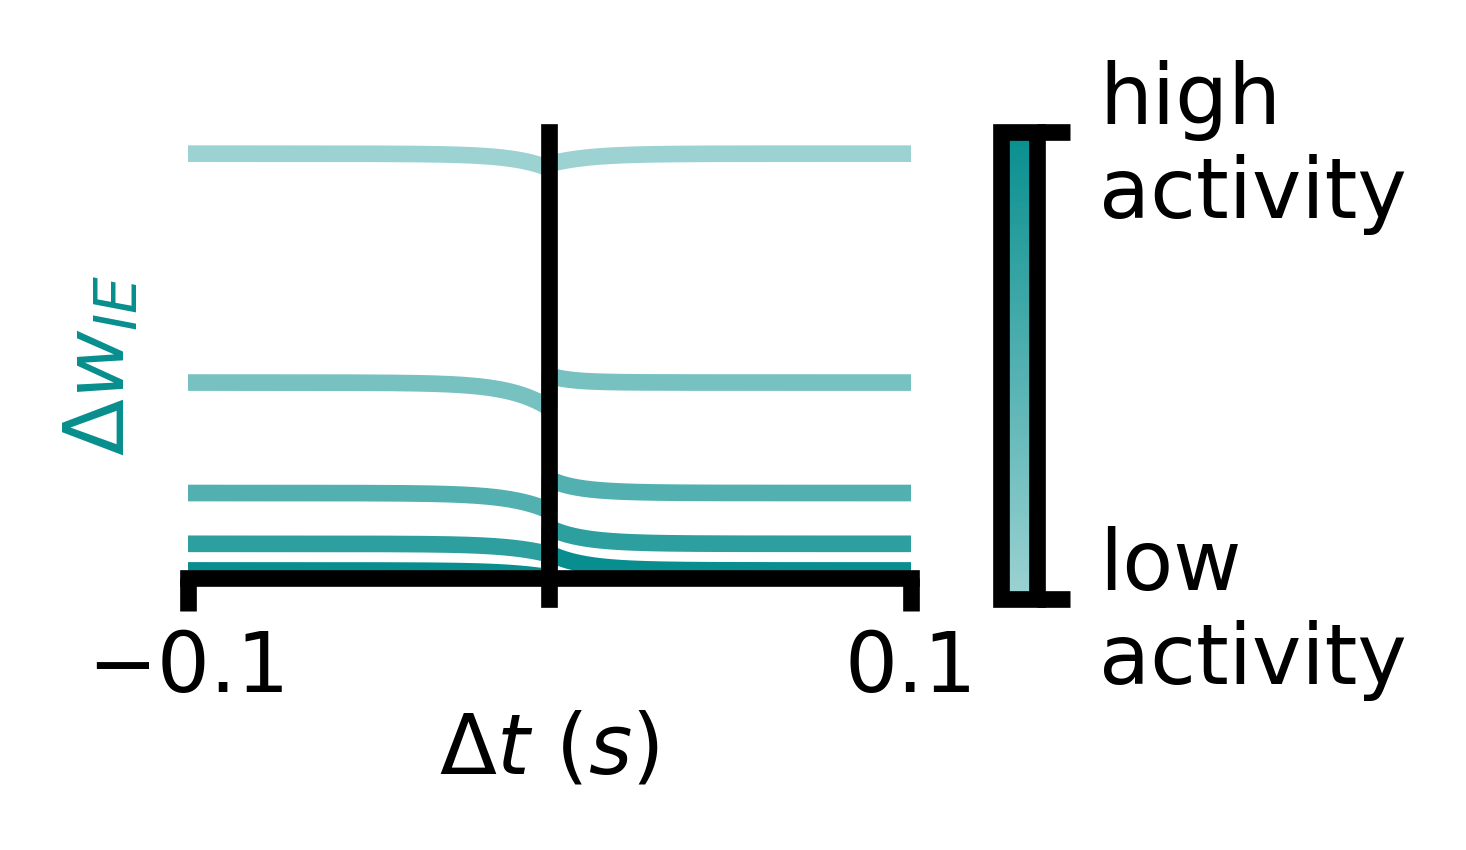

In [12]:
net_IE_pre = torch.load("/home/bconfavr/Documents/synapsesbi/notebooks/Task_design/test_model")
net_IE_post = torch.load("/home/bconfavr/Documents/synapsesbi/notebooks/Task_design/test_model")
dtype = torch.float

P = 0.4
colors = [((255-P*(255-8))/255, (255-P*(255-143))/255, (255-P*(255-143))/255), (8/256, 143/256, 143/256)]
cmap_ie = LinearSegmentedColormap.from_list("cmap_ie", colors)

rule = [1.29939720e-01, 4.79347276e-04, 2.96384186e-01, -4.67114270e-01, 4.24380839e-01, 6.47823513e-01, 3.48782279e-02, 3.41926664e-01, 3.47279757e-01, 3.47070426e-01, -3.15040410e-01, -6.94070637e-01, 1.87801853e-01, -2.09873557e-01, -3.75144660e-01, 8.85631084e-01, 1.43499836e-01, 6.42546713e-01, -2.99585074e-01, 5.86552262e-01, -9.38091934e-01, -3.76303978e-02, 8.75709915e+00]

# other example in supp
# rule = [ 0.02669999,  0.14428829,  0.76947457, -0.06014529, -0.22276115,  0.56693155, -0.15901111,  0.84426659,  0.44993687, -0.78366649,  0.69989562, -0.76975691, -0.49002439,  0.15140794, -0.11839931, -0.76659781,  0.53133011,  0.90907252, -0.80171049,  0.55569726, -0.8491962 ,  0.37236875,  8.93461609]


with torch.no_grad():
    net_IE_pre.eta = rule[1]
    net_IE_pre.l3.weight.copy_(torch.tensor(rule[12:16], dtype=dtype))
    net_IE_pre.l3.bias.copy_(torch.tensor([rule[16]], dtype=dtype))
    
with torch.no_grad():
    net_IE_post.eta = rule[1]
    net_IE_post.l3.weight.copy_(torch.tensor(rule[17:21], dtype=dtype))
    net_IE_post.l3.bias.copy_(torch.tensor([rule[21]], dtype=dtype))
    
rescale_trace=2.; 
rescale_v=15.;
rescale_w=1.;
rescale_cexc=15.;
rescale_cinh=15.;

n_cond = 5
var_dict = {"w": np.linspace(0,10, num=n_cond),
            "v": np.linspace(-0.07,-0.05, num=n_cond),
            "cexc": np.linspace(0,1, num=n_cond),
            "cinh": np.linspace(0,0.3, num=n_cond),
            "xpre": np.linspace(0,10, num=n_cond),
            "xpost": np.linspace(0,1, num=n_cond)}

aux.plot_rule_MLP(net_pre=net_IE_pre,
          net_post=net_IE_post,
          var_dict=var_dict,
          tau_pre1=0.01,
          tau_pre2=0.1,
          tau_post1=0.01,
          tau_post2=0.1,
          n_bins=1000,
          x_lim=[-0.1,0.1],
          dtype=dtype,
          xticks_pad=2,
          yticks_pad=0,
          color=color_ie,
          linewidth=2,
          axwidth=2,
          figsize=(2.5,1.5),
          rescale_trace=2,
          dpi=600,
          fontsize=10,
          x_ticks=[-0.1, 0.1],
          y_lim= None,
          y_ticks= [],
          x_label=r'$\Delta t \ (s)$',
          labelpad_xlabel=0,
          y_label=r'$\Delta w_{IE}$',
          labelpad_ylabel=45,
          color_ylabel=color_ie,
          cmap=cmap_ie,
          cbarticks=[0,1],
          cbarticklabels=["low\nactivity", "high\nactivity"])

#### Conditional correlation matrix

In [17]:
default_x_dict = default_x()

runs_path = "../runs_synapsesbi/bg_CVAIF_EEIE_T4wvceciMLP/"

with open(runs_path + "posterior_0r_f2_1wb_f2_2wbcv_f3_2wbwcac_f0_3rwbwcac_f0.pkl", "rb") as file:    
    mk_post = pickle.load(file)
    
    
posterior = mk_post.posterior

limits=torch.tensor([[0.0, .1], [0.0, .1], [-1.,1.], [-1.,1.], [-1.,1.], [-1.,1.],
            [-1.,1.], [-1.,1.], [-1.,1.], [-1.,1.], [-1.,1.], [-1.,1.],
            [-1.,1.], [-1.,1.], [-1.,1.], [-1.,1.], [-1.,1.], [-1.,1.],
            [-1.,1.], [-1.,1.], [-1.,1.], [-1.,1.]])

# post_num_samples = 3
# x = torch.tensor([[default_x_dict["w_creep"](1)] for i in range(post_num_samples)])
# x = torch.tensor([[9.9],[10],[10.1]])
# print(x)

# posterior.set_default_x(torch.tensor([[0, 0, 1]]))

posterior.set_default_x(torch.tensor([[5, 0.01, 0.01, 0.95]]))

NeuralPosteriorEnsemble sampler for potential_fn=<EnsemblePotential>

In [18]:
cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=posterior.sample((10,)),
    limits=limits,
)

Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

/home/bconfavr/miniconda3/envs/libdyn/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  outputs, _ = torch.triangular_solve(


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 3 posterior samples:   0%|          | 0/3 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

/home/bconfavr/miniconda3/envs/libdyn/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


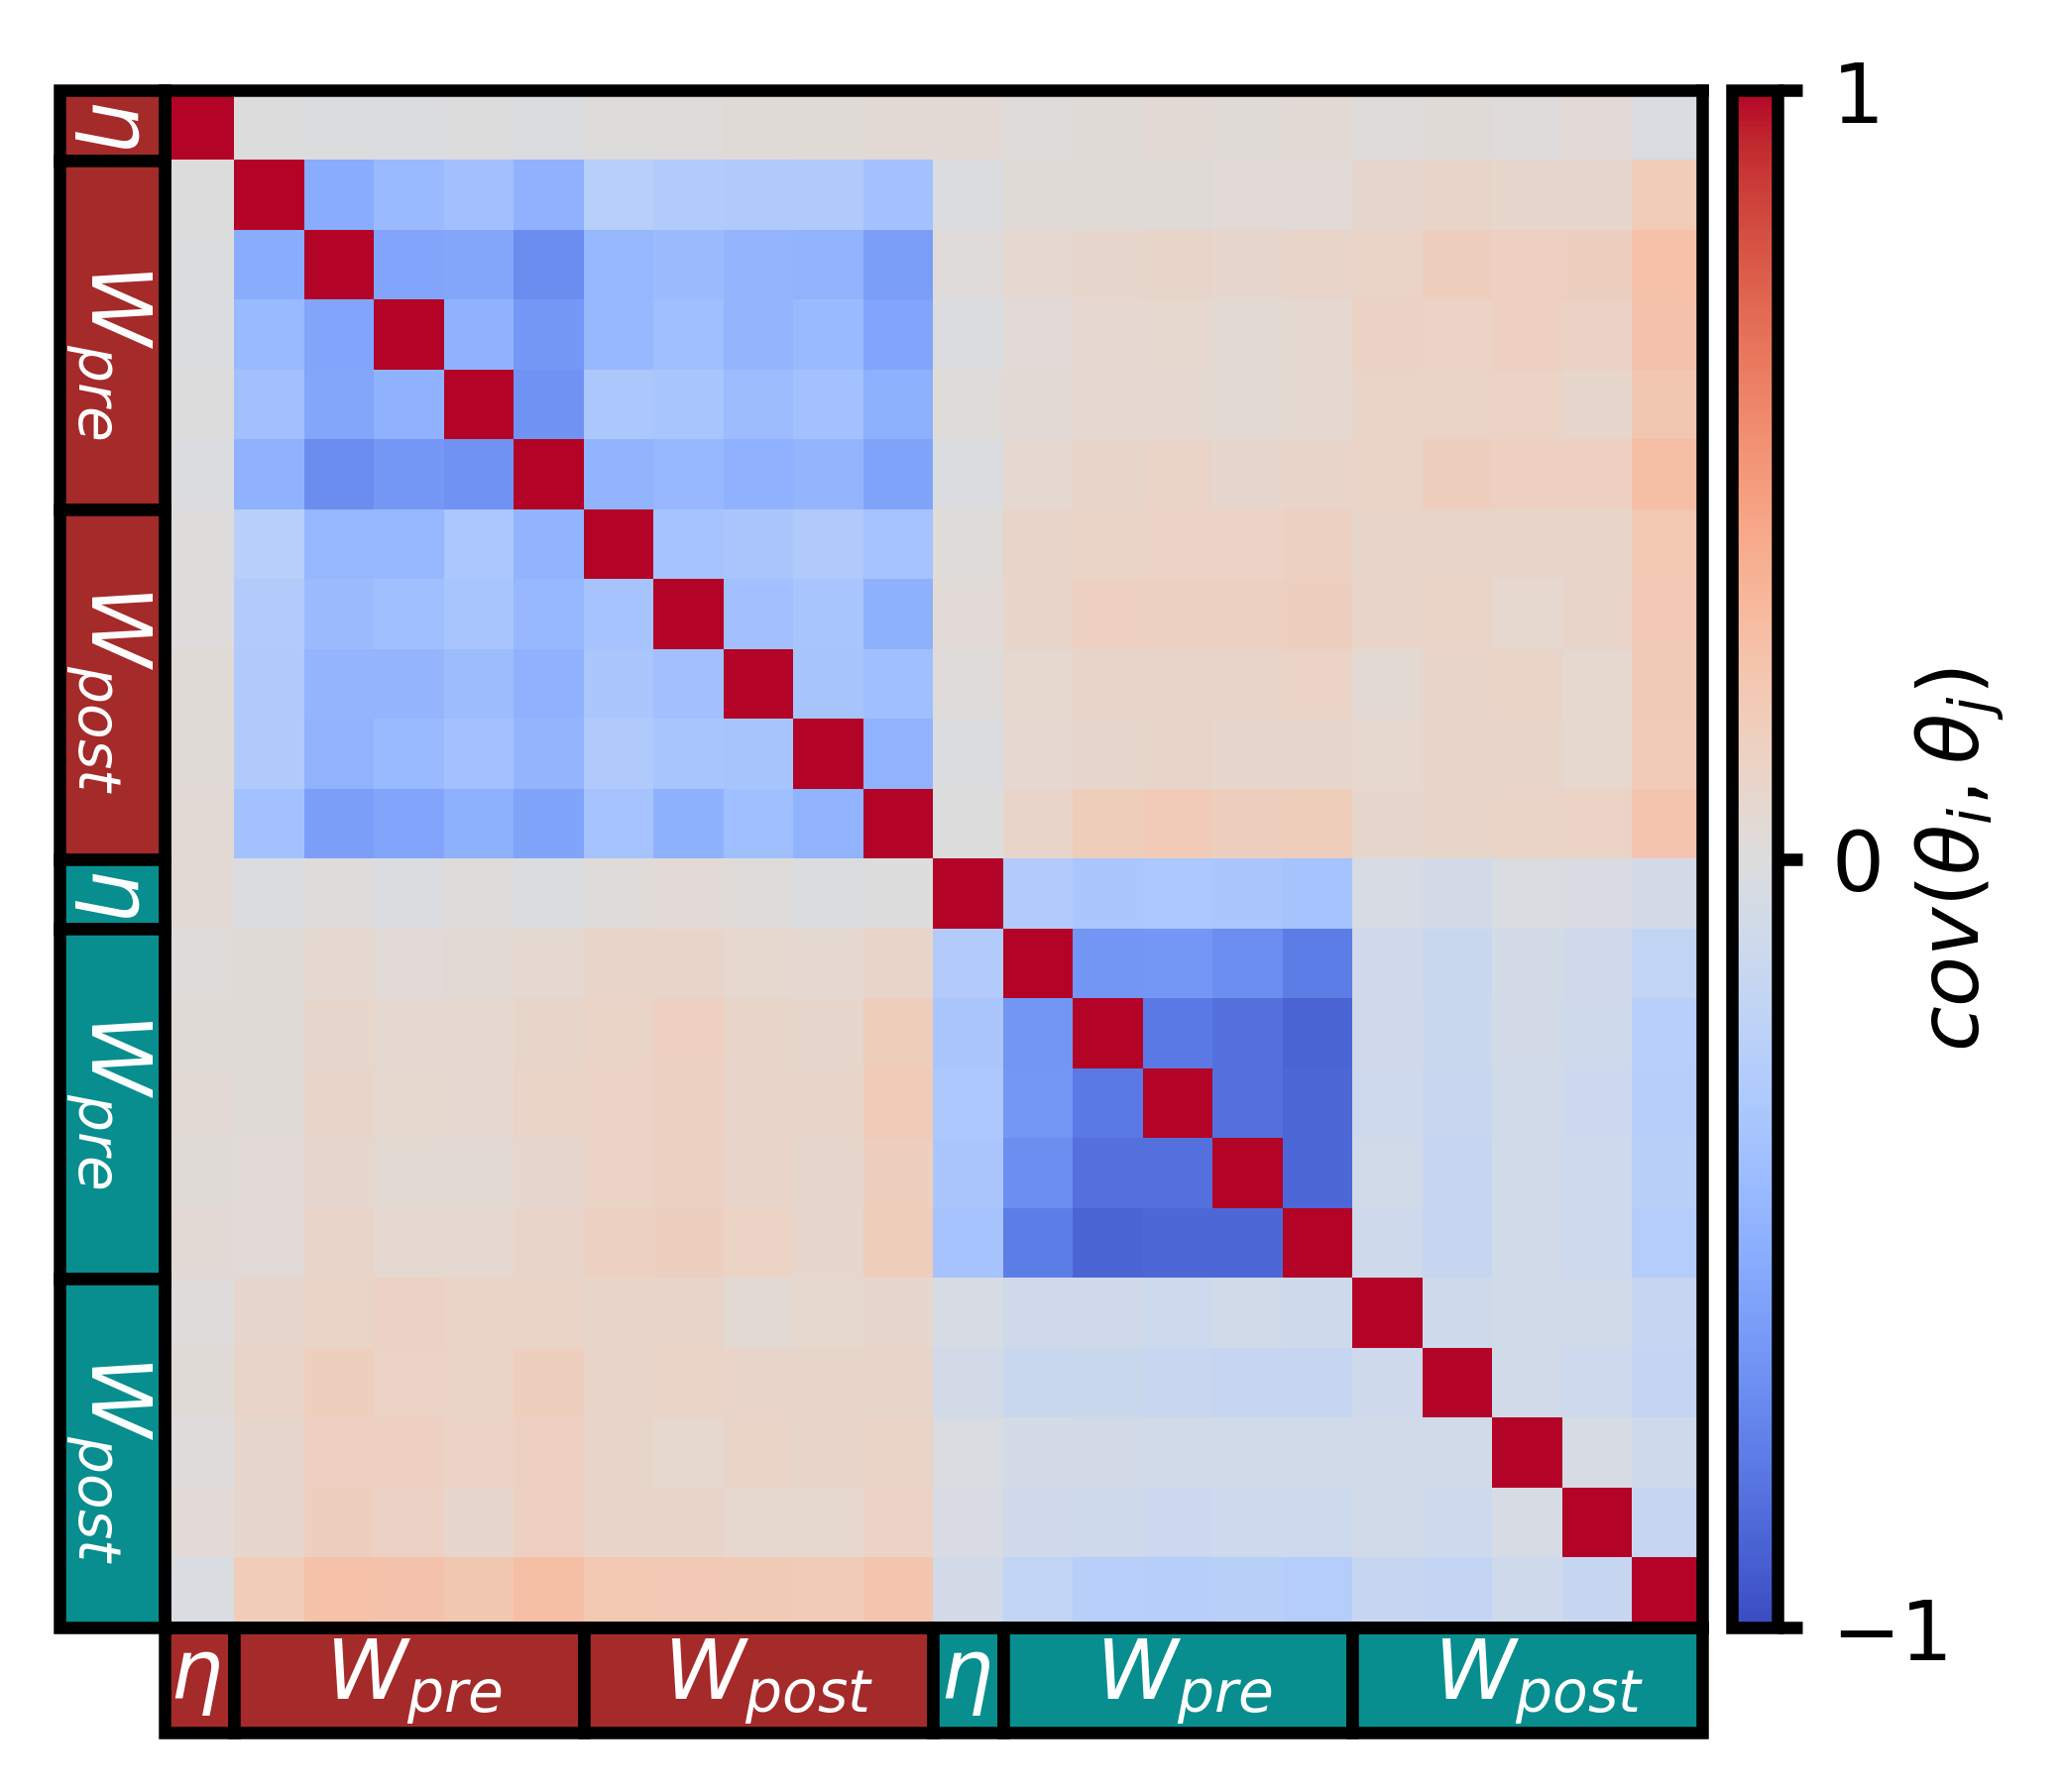

In [19]:
labelsx = [r"$\eta$", r"$W_{pre}$", r"$W_{post}$",
           r"$\eta$", r"$W_{pre}$", r"$W_{post}$"]

labelsy = [r"$\eta$", r"$W_{pre}$", r"$W_{post}$",
           r"$\eta$", r"$W_{pre}$", r"$W_{post}$"]

aux.plot_mat_MLP(cond_coeff_mat,
             figsize=(3.5,3.5),
             cmap="coolwarm",
             dpi=600,
             linewidth=1.5,
             fontsize=10,
             rotation=0,
             labelsx=labelsx,
             labelsy=labelsy,
             color_ee=color_ee,
             color_ie=color_ie,
             heatmap_label=r'$cov(\theta_i,\theta_j)$',
             cbarhandlepad=-5)

#### Pearson correlation matrix (non conditional)

In [14]:
cond_no_nan = ("rate", 0, 1000)
cond_r = ("rate", 1, 50)
cond_cv = ("cv_isi", 0.7, 1000)
cond_kl = ("kl_isi", 0, 0.5)
cond_sf = ("spatial_Fano", 0.5, 2.5)
cond_tf = ("temporal_Fano", 0.5, 2.5)
cond_ac = ("auto_cov", 0, 0.1)
cond_fft = ("fft", 0, 1)
cond_wb = ("w_blow", 0, 0.1)
cond_srt = ("std_rate_temporal", 0, 0.5)
cond_srs = ("std_rate_spatial", 0, 5)
cond_scv = ("std_cv", 0, 0.2)
cond_wc = ("w_creep", 0, 0.05)
cond_ri = ("rate_i", 1, 50)
cond_weef = ("weef", 0, 0.5)
cond_wief = ("wief", 0, 5)

cond_all = (cond_r,cond_ri,
            cond_wb,cond_wc,cond_weef, cond_wief,
            cond_ac,cond_cv,cond_fft,cond_srt,cond_srs,cond_sf,cond_tf,cond_scv)

condition = apply_n_conditions(dataset,cond_all)

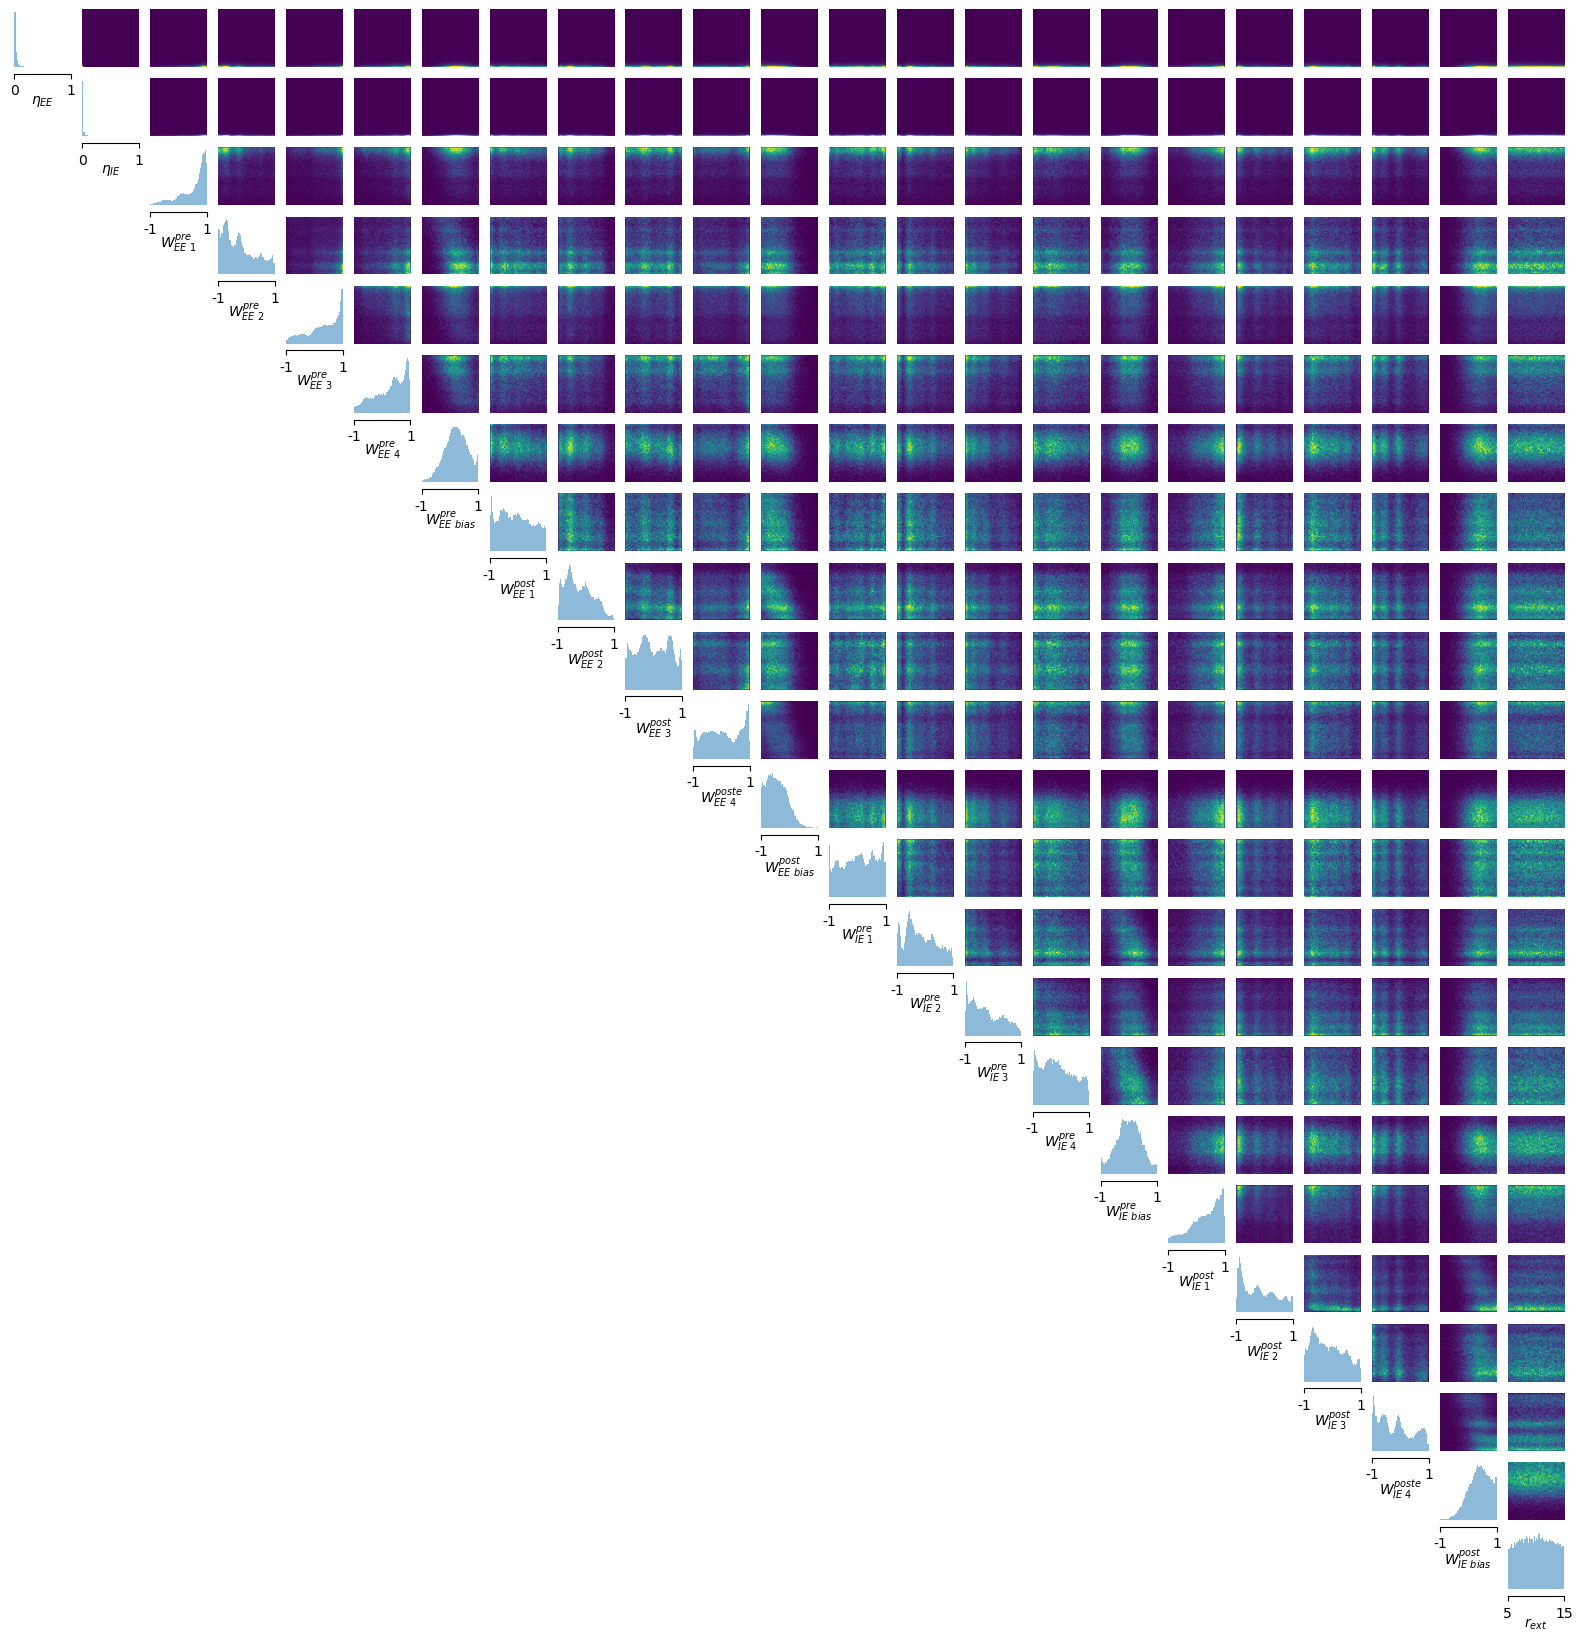

In [15]:
from sbi.analysis import pairplot

dim_theta = len(dataset['theta'][0])
fig, axes = pairplot(samples=[dataset[condition]['theta']],
                     diag='hist',
                     upper='hist',
                     hist_diag= {'alpha': .5, 'bins': 50, 'density': True, 'histtype': 'stepfilled'},
                     points_colors=["tab:red"],
                     points_diag = {"lw": 4})

labels = [r"$\eta_{EE}$", r"$\eta_{IE}$", 
          r"$W^{pre}_{EE\ 1}$", r"$W^{pre}_{EE\ 2}$", r"$W^{pre}_{EE\ 3}$", r"$W^{pre}_{EE\ 4}$", r"$W^{pre}_{EE\ bias}$",
          r"$W^{post}_{EE\ 1}$", r"$W^{post}_{EE\ 2}$", r"$W^{post}_{EE\ 3}$", r"$W^{poste}_{EE\ 4}$", r"$W^{post}_{EE\ bias}$",
          r"$W^{pre}_{IE\ 1}$", r"$W^{pre}_{IE\ 2}$", r"$W^{pre}_{IE\ 3}$", r"$W^{pre}_{IE\ 4}$", r"$W^{pre}_{IE\ bias}$",
          r"$W^{post}_{IE\ 1}$", r"$W^{post}_{IE\ 2}$", r"$W^{post}_{IE\ 3}$", r"$W^{poste}_{IE\ 4}$", r"$W^{post}_{IE\ bias}$",
          r"$r_{ext}$"]

for i in range(dim_theta):
    for j in range(i, dim_theta): 
        if i!=j:
            axes[i, j].set_xticks([])
        if i==j:
            axes[i, j].set_xlabel(labels[i], fontsize=10, labelpad=-3)
            if i in [0,1]:
                axes[i, j].set_xticks([0,1])
                axes[i, j].set_xlim([0,1])
                axes[i, j].set_xticklabels(["0", "1"])
            elif i == 22:
                axes[i, j].set_xticks([5,15])
                axes[i, j].set_xlim([5,15])
                axes[i, j].set_xticklabels(["5", "15"])
            else:
                axes[i, j].set_xticks([-1,1])
                axes[i, j].set_xlim([-1,1])

fig.patch.set_facecolor("white")
fig.set_size_inches(20, 20)
plt.show()

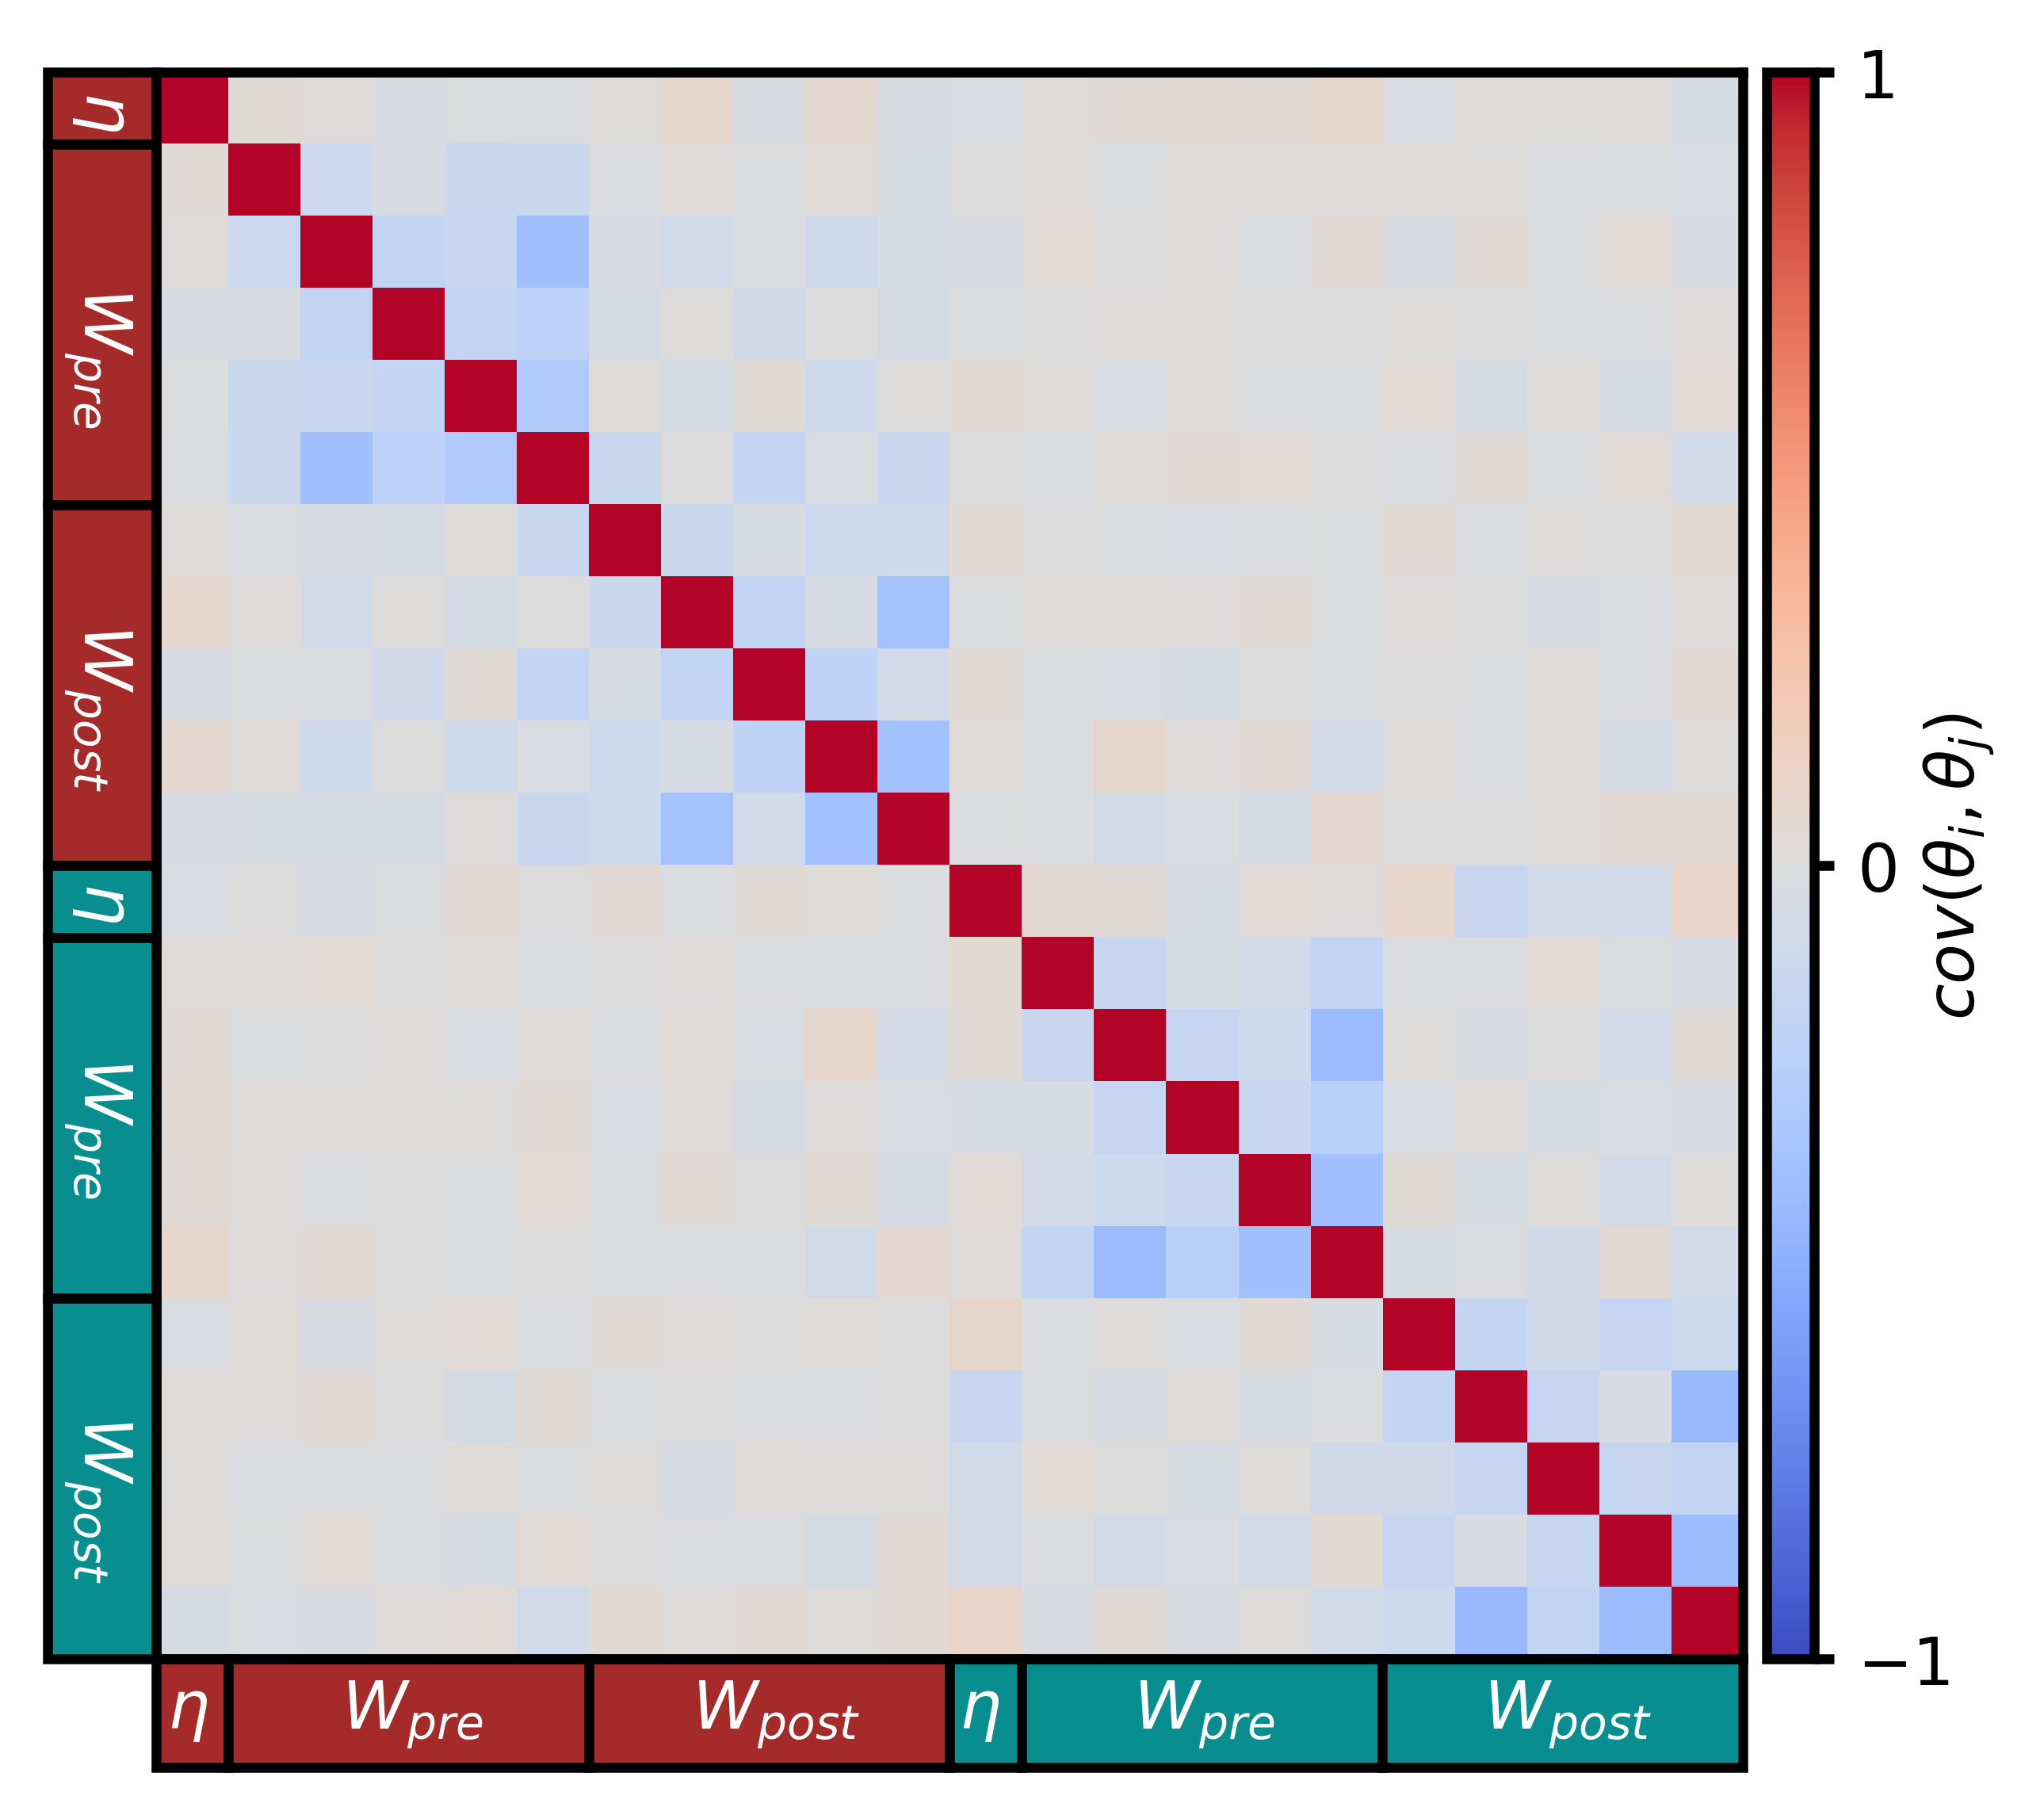

In [16]:
corr_matrix_marginal = np.corrcoef(dataset[condition]['theta'].T)
   
labelsx = [r"$\eta$", r"$W_{pre}$", r"$W_{post}$",
           r"$\eta$", r"$W_{pre}$", r"$W_{post}$"]

labelsy = [r"$\eta$", r"$W_{pre}$", r"$W_{post}$",
           r"$\eta$", r"$W_{pre}$", r"$W_{post}$"]

aux.plot_mat_MLP(corr_matrix_marginal,
             figsize=(4.5,4.5),
             cmap="coolwarm",
             dpi=600,
             linewidth=1.5,
             fontsize=10,
             rotation=0,
             labelsx=labelsx,
             labelsy=labelsy,
             color_ee=color_ee,
             color_ie=color_ie,
             heatmap_label=r'$cov(\theta_i,\theta_j)$',
             cbarhandlepad=-5)